In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import hypernetx.algorithms.hypergraph_modularity as hmod
import pandas as pd
import igraph as ig
import hypernetx as hnx
import statistics
import itertools
import math
import community ## package python-louvain
import random
import pickle
from itertools import combinations
from PyComplexHeatmap import *

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from hnxClusteringFunctions import *
from incidenceToProjection import *
from edgeWeightFormulations import bounded_lengthFreq
from utils import flatten

 No module named 'celluloid'. If you need to use hypernetx.algorithms.contagion, please install additional packages by running the following command: pip install .['all']


# Read and process input

In [3]:
## get intra-chromosomal genes

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}NlaIII_GM12878_output_byChr/NlaIII_GM12878_chr19.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

## Get frequency of length distributions given cardinality
with open(f'{dataDir}../v0_hypergraphSimulations/freqLensGivenCard.pkl', 'rb') as pickle_file:
    freqLenPerCard = pickle.load(pickle_file)

global freqLenPerCard

In [4]:
## Add bin ID
chr19 = fullBed[fullBed['chr']=="chr19"]
binSize = 10**6
chrBins = [x for x in range(0,chromSizes['chr19']+binSize,binSize)]
chr19_binned = pd.cut(chr19['start'],bins = chrBins, labels = ["Bin_"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
chr19_wBinID = chr19.merge(chr19_binned,left_index=True,right_index=True)

### Subsample reads for code testing

In [44]:
random.seed(123)
randomReadIdx = random.sample(list(chr19_wBinID['ID']),10**5)
subsetDF = chr19_wBinID[chr19_wBinID['ID'].isin(randomReadIdx)]
print(subsetDF.shape)
chr19IncDF = pd.pivot_table(data=subsetDF[['ID', 'binID']], index='binID', columns='ID', aggfunc=lambda x: 1, fill_value=0)
print(chr19IncDF.shape)

(352131, 16)
(57, 98573)


In [45]:
random.seed(234)
randomReadIdx = random.sample(list(chr19_wBinID['ID']),10**5)
subsetDF2 = chr19_wBinID[chr19_wBinID['ID'].isin(randomReadIdx)]
print(subsetDF2.shape)
chr19IncDF2 = pd.pivot_table(data=subsetDF2[['ID', 'binID']], index='binID', columns='ID', aggfunc=lambda x: 1, fill_value=0)
print(chr19IncDF2.shape)

(354355, 16)
(57, 98598)


In [46]:
colSums_chr19IncDF = chr19IncDF.sum()
intraChrom19 = chr19IncDF.loc[:, colSums_chr19IncDF >2]
print(intraChrom19.shape)

colSums_chr19IncDF2 = chr19IncDF2.sum()
intraChrom192 = chr19IncDF2.loc[:, colSums_chr19IncDF2 >2]
print(intraChrom192.shape)

(57, 26315)
(57, 26505)


In [47]:
ic19_full = hnx.Hypergraph.from_incidence_dataframe(intraChrom19)
weights = pd.Series([bounded_lengthFreq(list(intraChrom19[c])) for c in intraChrom19.columns], index=intraChrom19.columns)
print(ic19_full.number_of_nodes())
print(ic19_full.number_of_edges())

57
26315


In [48]:
ic19_full2 = hnx.Hypergraph.from_incidence_dataframe(intraChrom192)
weights2 = pd.Series([bounded_lengthFreq(list(intraChrom192[c])) for c in intraChrom192.columns], index=intraChrom192.columns)
print(ic19_full2.number_of_nodes())
print(ic19_full2.number_of_edges())

57
26505


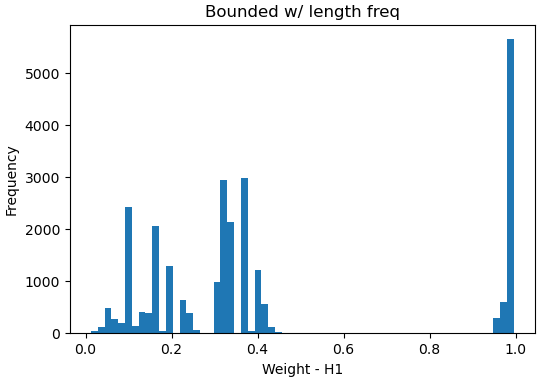

In [49]:
# Generate a histogram
plt.figure(figsize=(6,4))
plt.hist(weights, bins='auto')

# Add labels and title
plt.xlabel('Weight - H1')
plt.ylabel('Frequency')
plt.title('Bounded w/ length freq')

# Display the histogram
plt.show()

In [50]:
chrom19_hiC = makeHiC_fromInc(intraChrom19)
chrom19_normHiC = makeNorm_HiC_fromInc(intraChrom19,weights)

In [51]:
chrom19_hiC2 = makeHiC_fromInc(intraChrom192)
chrom19_normHiC2 = makeNorm_HiC_fromInc(intraChrom192,weights2)

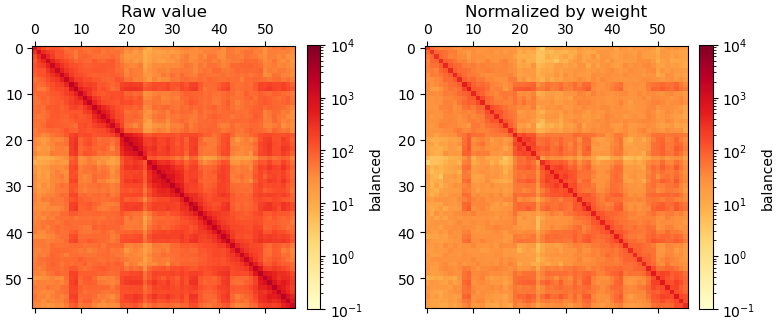

In [56]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(8,4),
    ncols=2, nrows = 1)

ax = axs[0]
im = ax.matshow(
    chrom19_hiC,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

ax = axs[1]
im = ax.matshow(
    chrom19_normHiC,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4,vmin = 0.1)
)
ax.set_title("Normalized by weight", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

plt.tight_layout()
plt.show()

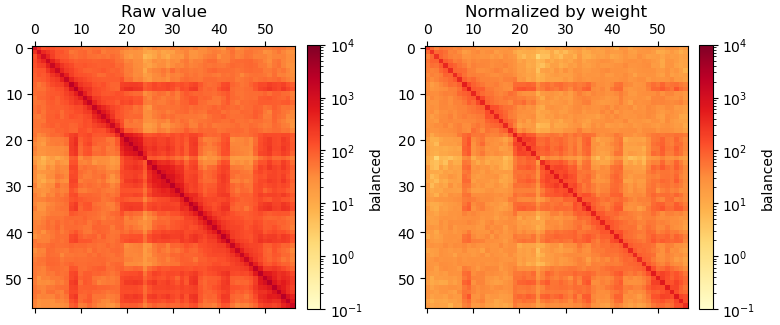

In [57]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(8,4),
    ncols=2, nrows = 1)

ax = axs[0]
im = ax.matshow(
    chrom19_hiC2,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

ax = axs[1]
im = ax.matshow(
    chrom19_normHiC2,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4,vmin = 0.1)
)
ax.set_title("Normalized by weight", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

plt.tight_layout()
plt.show()

In [58]:
h1_nodes = []
for e in ic19_full.edges:
    h1_nodes.append(tuple(ic19_full.edges[e]))

h2_nodes = []
for e in ic19_full2.edges:
    h2_nodes.append(tuple(ic19_full2.edges[e]))

In [59]:
common_elements = set(h1_nodes).intersection(set(h2_nodes))
print(len(common_elements),len(h1_nodes),len(h2_nodes))

5061 26315 26505


In [60]:
toRemove1 = []
for e in ic19_full.edges:
    if tuple(ic19_full.edges[e]) in common_elements:
        toRemove1.append(e)

toRemove2 = []
for e in ic19_full2.edges:
    if tuple(ic19_full2.edges[e]) in common_elements:
        toRemove2.append(e)

In [61]:
ic19_pruned = ic19_full.remove_edges(keys = toRemove1)
ic192_pruned = ic19_full2.remove_edges(keys = toRemove2)

In [62]:
inc1 = ic19_pruned.incidence_dataframe()
hic_pruned1 = makeHiC_fromInc(inc1)

inc2 = ic192_pruned.incidence_dataframe()
hic_pruned2 = makeHiC_fromInc(inc2)
hic_pruned2.shape


(57, 57)

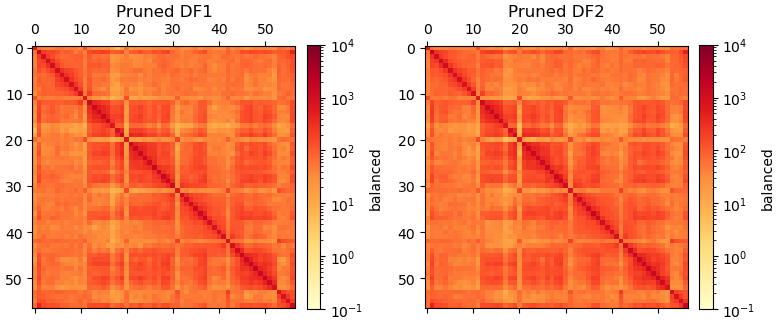

In [63]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(8,4),
    ncols=2, nrows = 1)

ax = axs[0]
im = ax.matshow(
    hic_pruned1,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Pruned DF1", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

ax = axs[1]
im = ax.matshow(
    hic_pruned2,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4,vmin = 0.1)
)
ax.set_title("Pruned DF2", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

plt.tight_layout()
plt.show()

In [84]:
for e in ic19_full.edges:
    ic19_full.edges[e].weight = weights[e]
rand_qh_pI_BLF, kumClust_pI_BLF, louClust_pI_BLF = compareClusteringMethods(ic19_full,K = 10)

10  random clusters, qH =  -0.0007667983345326507
Num kumar clusters =  5
Kumar qH = 0.2916291878521191
[{'Bin_4', 'Bin_5', 'Bin_15', 'Bin_26', 'Bin_24', 'Bin_38', 'Bin_36', 'Bin_23', 'Bin_29', 'Bin_8', 'Bin_10', 'Bin_30', 'Bin_35', 'Bin_28', 'Bin_33', 'Bin_11', 'Bin_16', 'Bin_3', 'Bin_31', 'Bin_21', 'Bin_37', 'Bin_2', 'Bin_34', 'Bin_12', 'Bin_32', 'Bin_1', 'Bin_17', 'Bin_9', 'Bin_6', 'Bin_13', 'Bin_7', 'Bin_27', 'Bin_22', 'Bin_39', 'Bin_14', 'Bin_25'}, {'Bin_19', 'Bin_41', 'Bin_48', 'Bin_49', 'Bin_20', 'Bin_46', 'Bin_42', 'Bin_45', 'Bin_40', 'Bin_18', 'Bin_47', 'Bin_44', 'Bin_43'}, {'Bin_73', 'Bin_55', 'Bin_57', 'Bin_71', 'Bin_50', 'Bin_63', 'Bin_60', 'Bin_59', 'Bin_74', 'Bin_70', 'Bin_64', 'Bin_76', 'Bin_69', 'Bin_75', 'Bin_67', 'Bin_62', 'Bin_65', 'Bin_66', 'Bin_61', 'Bin_72', 'Bin_68', 'Bin_56', 'Bin_58'}, {'Bin_78', 'Bin_90', 'Bin_86', 'Bin_81', 'Bin_80', 'Bin_83', 'Bin_77', 'Bin_88', 'Bin_101', 'Bin_95', 'Bin_103', 'Bin_91', 'Bin_100', 'Bin_92', 'Bin_82', 'Bin_85', 'Bin_93', 'Bin

In [146]:
clusterSizes = [len(item) for item in kumClust_pI_BLF]
clusterIDs = flatten([[i]*clusterSizes[i] for i in range(len(clusterSizes))])
kumClusters = flatten([list(item) for item in kumClust_pI_BLF])
orderedClustIDs= [clusterIDs[kumClusters.index(bID)] for bID in chrom19_normHiC.columns]

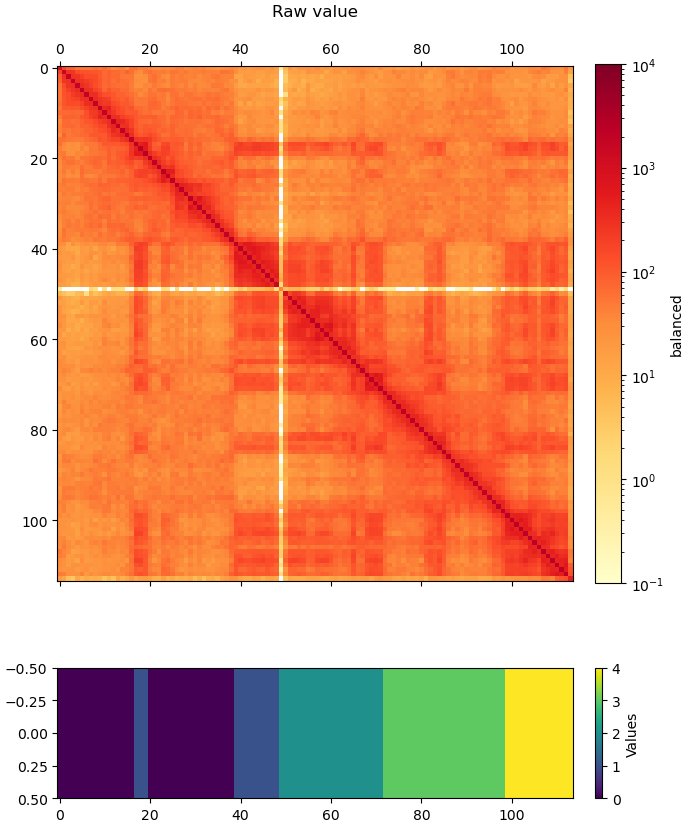

In [163]:
f, axs = plt.subplots(
    figsize=(7,9),
    ncols=1, nrows = 2,
    gridspec_kw={'height_ratios': [1, 0.2]})

ax = axs[0]
im = ax.matshow(
    chrom19_normHiC,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

ax = axs[1]
im = ax.imshow(np.array([orderedClustIDs]), cmap="viridis", aspect="auto")
# Add colorbar to show legend
cbar = plt.colorbar(im,ax = ax, 
fraction=0.046, pad=0.04,
ticks=np.arange(len(np.unique(orderedClustIDs))))
cbar.set_label('Values')

plt.tight_layout()
plt.show()

### Set weights to zero if they fall below a cutoff

In [130]:
wCutoff = 0.5
updatedWeights = pd.Series([0 if x <= wCutoff else x for x in weights],index=intraChrom19.columns)


In [133]:
chrom19_normHiC_updatedWeights = makeNorm_HiC_fromInc(intraChrom19,updatedWeights)

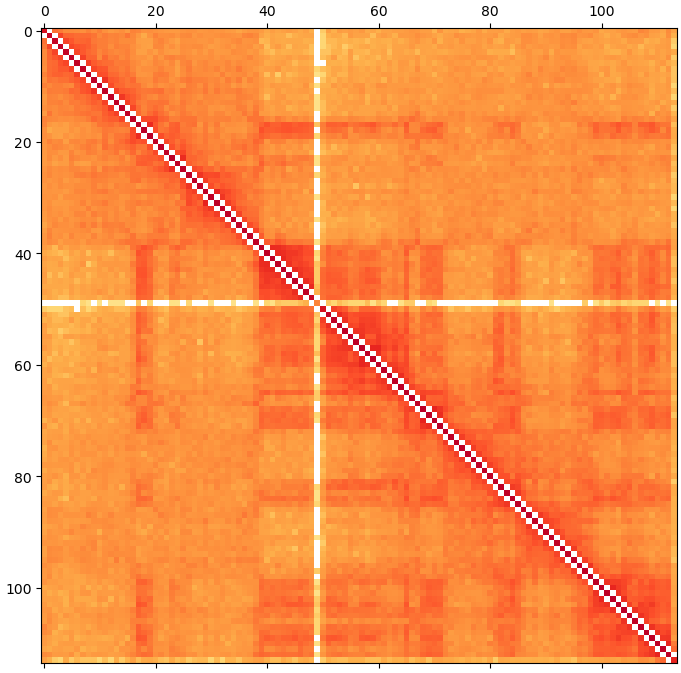

In [135]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(7,7),
    ncols=1, nrows = 1)

im = axs.matshow(
    chrom19_normHiC_updatedWeights,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

plt.tight_layout()
plt.show()